In [1]:
import uuid

from IPython.core.display_functions import display

from tapestry.evaluate import evaluate_tensor_value
from tapestry.graph_algorithms import (
    strip_blocks,
    shard_max_dim,
    specialize_read_slices,
    strip_orphan_values,
    section_plan_max_dim,
    expand_section_plans,
)
from tapestry.jupyter_utils import display_graph
import numpy as np
import torch
from typing import Optional, Dict, Tuple

from tapestry.expression_graph import (
    BlockOperation,
    PinnedTensor,
    TapestryGraph,
    AggregateTensor,
    TensorValue,
)
from tapestry.zspace import EmbeddingMode, ZRange, ZRangeMap, ZTransform, assert_shape

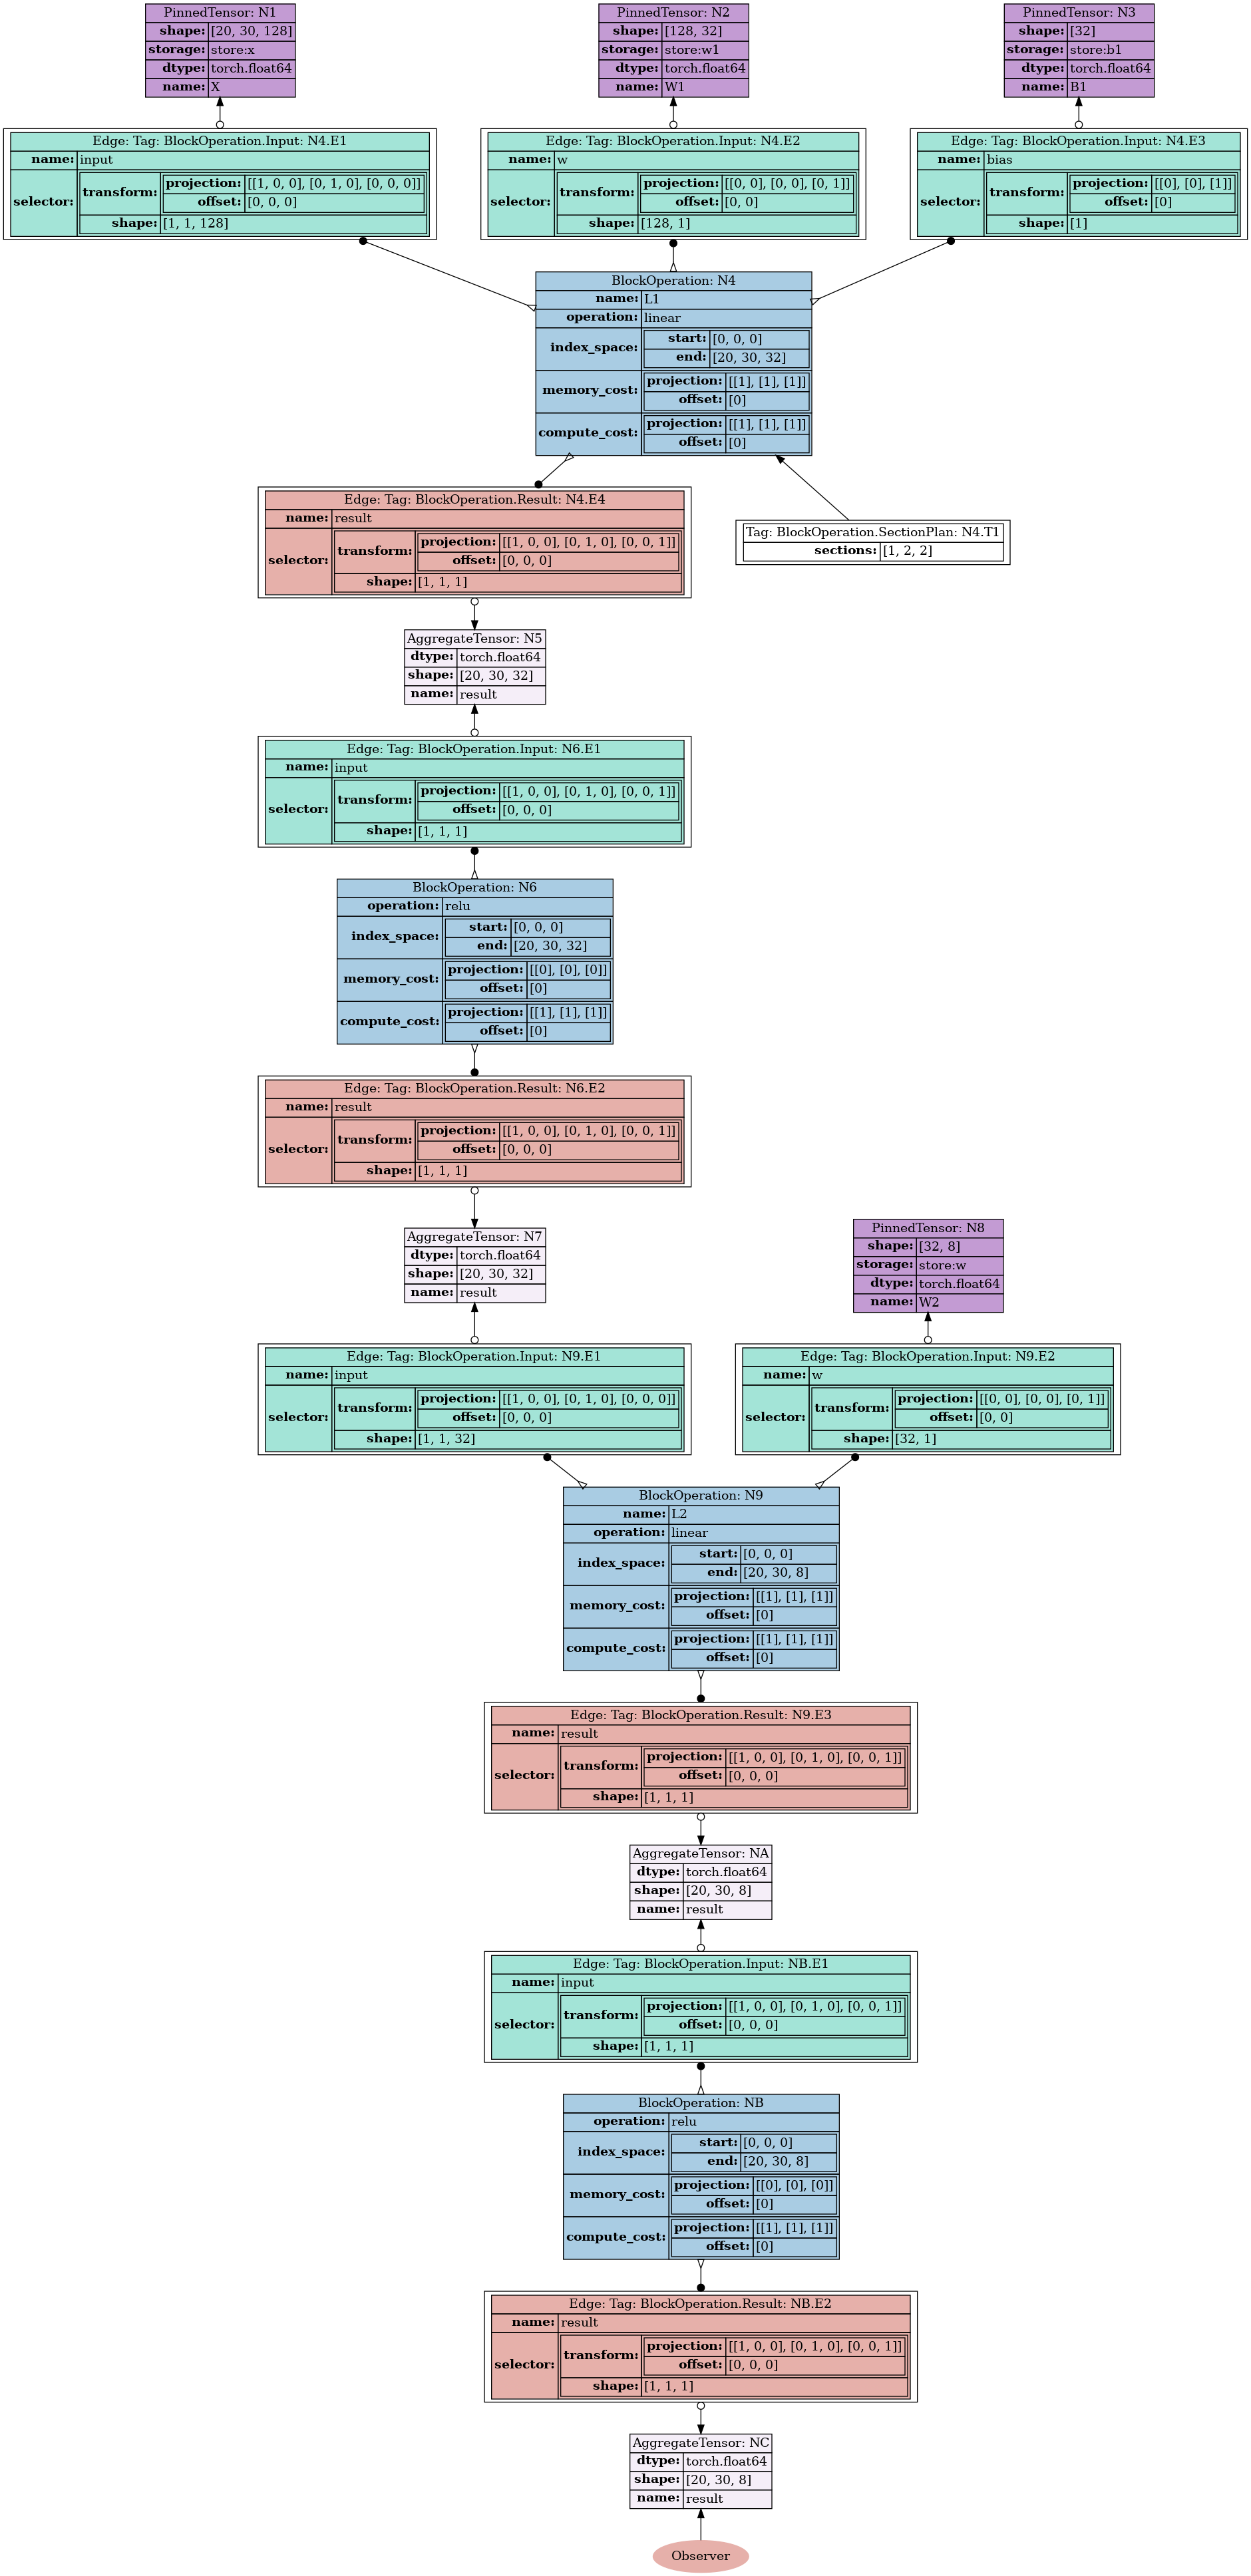

In [2]:
def linear_impl(
    params: Dict[str, torch.Tensor],
) -> Dict[str, torch.Tensor]:
    x = params["input"]
    w = params["w"]
    bias = params.get("bias")
    return {"result": torch.nn.functional.linear(x, w.T, bias)}


def linear_op(
    *,
    name: str = None,
    x: TensorValue,
    w: TensorValue,
    bias: Optional[TensorValue] = None,
) -> AggregateTensor:
    graph = x.assert_graph()
    assert w.graph == graph

    assert len(w.shape) == 2, w.shape
    in_dim = w.shape[0]
    out_dim = w.shape[1]

    assert_shape(
        x.shape[-1:],
        w.shape[:1],
        "input shape {xshape} in_dim {actual} incompatible "
        "with weight shape {wshape} in_dim {expected}",
        xshape=x.shape,
        wshape=w.shape,
    )

    index_space = ZRange(x.shape[:-1].tolist() + [out_dim])

    op = graph.add_node(
        BlockOperation(
            name=name,
            operation="linear",
            index_space=index_space,
            compute_cost=ZTransform(
                projection=np.ones((index_space.ndim, 1)),
            ),
            memory_cost=ZTransform(
                projection=np.ones((index_space.ndim, 1)),
            ),
        )
    )

    op.bind_input(
        name="input",
        value=x,
        selector=ZRangeMap(
            transform=ZTransform(
                projection=[
                    [1, 0],
                    [0, 0],
                ],
            ),
            shape=[1, in_dim],
        ).embed(op.index_space.ndim, mode=EmbeddingMode.TILE),
    )

    projection = np.zeros((index_space.ndim, 2))
    projection[-1, -1] = 1

    op.bind_input(
        name="w",
        value=w,
        selector=ZRangeMap(
            transform=ZTransform(
                projection=projection,
            ),
            shape=[in_dim, 1],
        ).embed(op.index_space.ndim, mode=EmbeddingMode.CLIP),
    )

    if bias is not None:
        assert_shape(
            bias.shape,
            w.shape[-1:],
            "bias shape {actual} != weight [out_dim] {expected}",
        )

        op.bind_input(
            name="bias",
            value=bias,
            selector=ZRangeMap(
                transform=ZTransform(projection=[[0], [1]]),
                shape=[1],
            ).embed(op.index_space.ndim, mode=EmbeddingMode.CLIP),
        )

    result = op.bind_result(
        name="result",
        selector=ZRangeMap(
            transform=ZTransform(
                projection=[[1, 0], [0, 1]],
            ),
            shape=[1, 1],
        ).embed(op.index_space.ndim, mode=EmbeddingMode.TILE),
        dtype=x.dtype,
    )

    return result


def relu_impl(
    params: Dict[str, torch.Tensor],
) -> Dict[str, torch.Tensor]:
    x = params["input"]
    return {"result": torch.nn.functional.relu(x)}


def relu_op(
    value: TensorValue,
) -> AggregateTensor:
    graph = value.assert_graph()

    index_space = ZRange(value.shape)

    op = graph.add_node(
        BlockOperation(
            operation="relu",
            index_space=index_space,
            compute_cost=ZTransform(
                projection=np.ones((index_space.ndim, 1)),
            ),
            memory_cost=ZTransform(
                projection=np.zeros((index_space.ndim, 1)),
            ),
        )
    )

    selector = ZRangeMap.identity_map().embed(
        op.index_space.ndim,
        mode=EmbeddingMode.TILE,
    )

    op.bind_input(
        name="input",
        value=value,
        selector=selector,
    )

    result = op.bind_result(
        name="result",
        selector=selector,
        dtype=value.dtype,
    )

    return result


def build_example_graph():
    g = TapestryGraph()

    x = g.add_node(
        PinnedTensor(
            name="X",
            shape=[20, 30, 128],
            dtype=torch.float64,
            storage="store:x",
        )
    )

    w1 = g.add_node(
        PinnedTensor(
            name="W1",
            shape=[128, 32],
            dtype=torch.float64,
            storage="store:w1",
        )
    )

    b1 = g.add_node(
        PinnedTensor(
            name="B1",
            shape=[32],
            dtype=torch.float64,
            storage="store:b1",
        )
    )

    a = linear_op(name="L1", x=x, w=w1, bias=b1)

    y = relu_op(a)

    w2 = g.add_node(
        PinnedTensor(
            name="W2",
            shape=[32, 8],
            dtype=torch.float64,
            storage="store:w",
        )
    )

    z = relu_op(linear_op(name="L2", x=y, w=w2))

    g.mark_observed(z)

    return g


unsharded = build_example_graph()

g = unsharded.clone()

# TODO: better node path / name lookup semantics.
# Q: are names unique? grouped? here are errors thrown?
# _we_ have unique IDs; might be easier to require exeternal maps.
l1 = g.list_nodes(BlockOperation, filter=lambda n: n.name == "L1")[0]

# demonstrate manual sectioning.
l1.attach_section_plan([1, 2, 2])

display_graph(g)

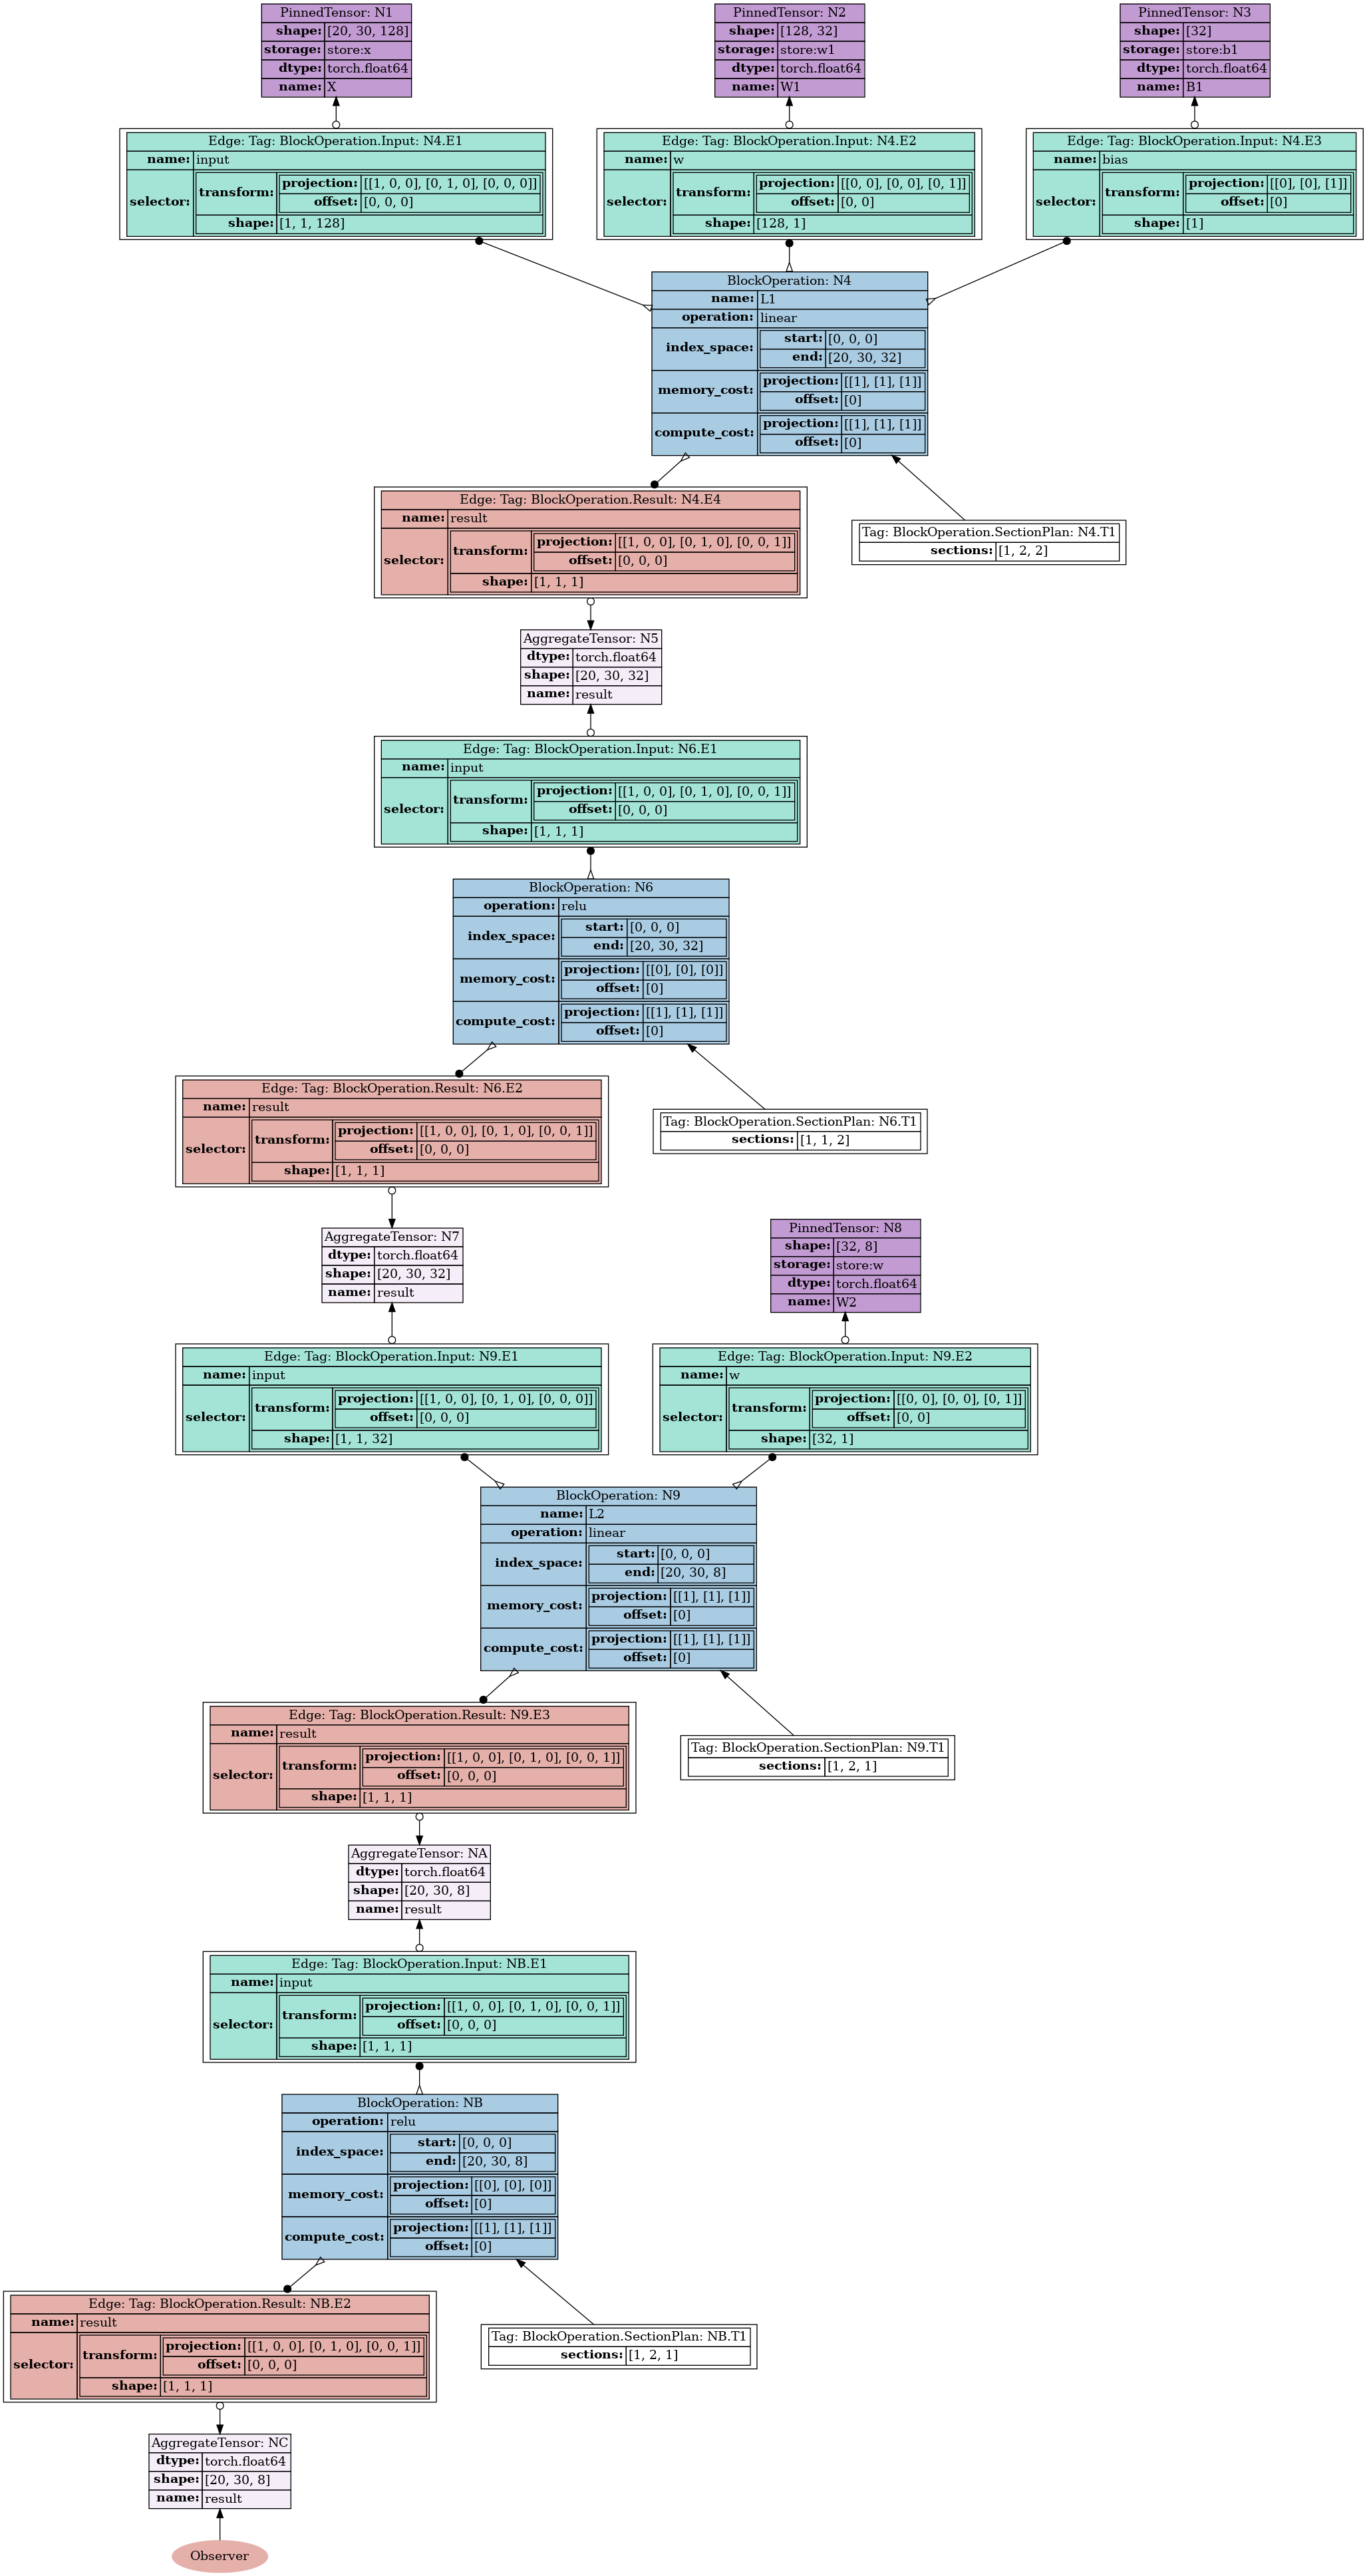

In [3]:
sectioned = g.clone()
section_plan_max_dim(sectioned, 2)
display_graph(sectioned)

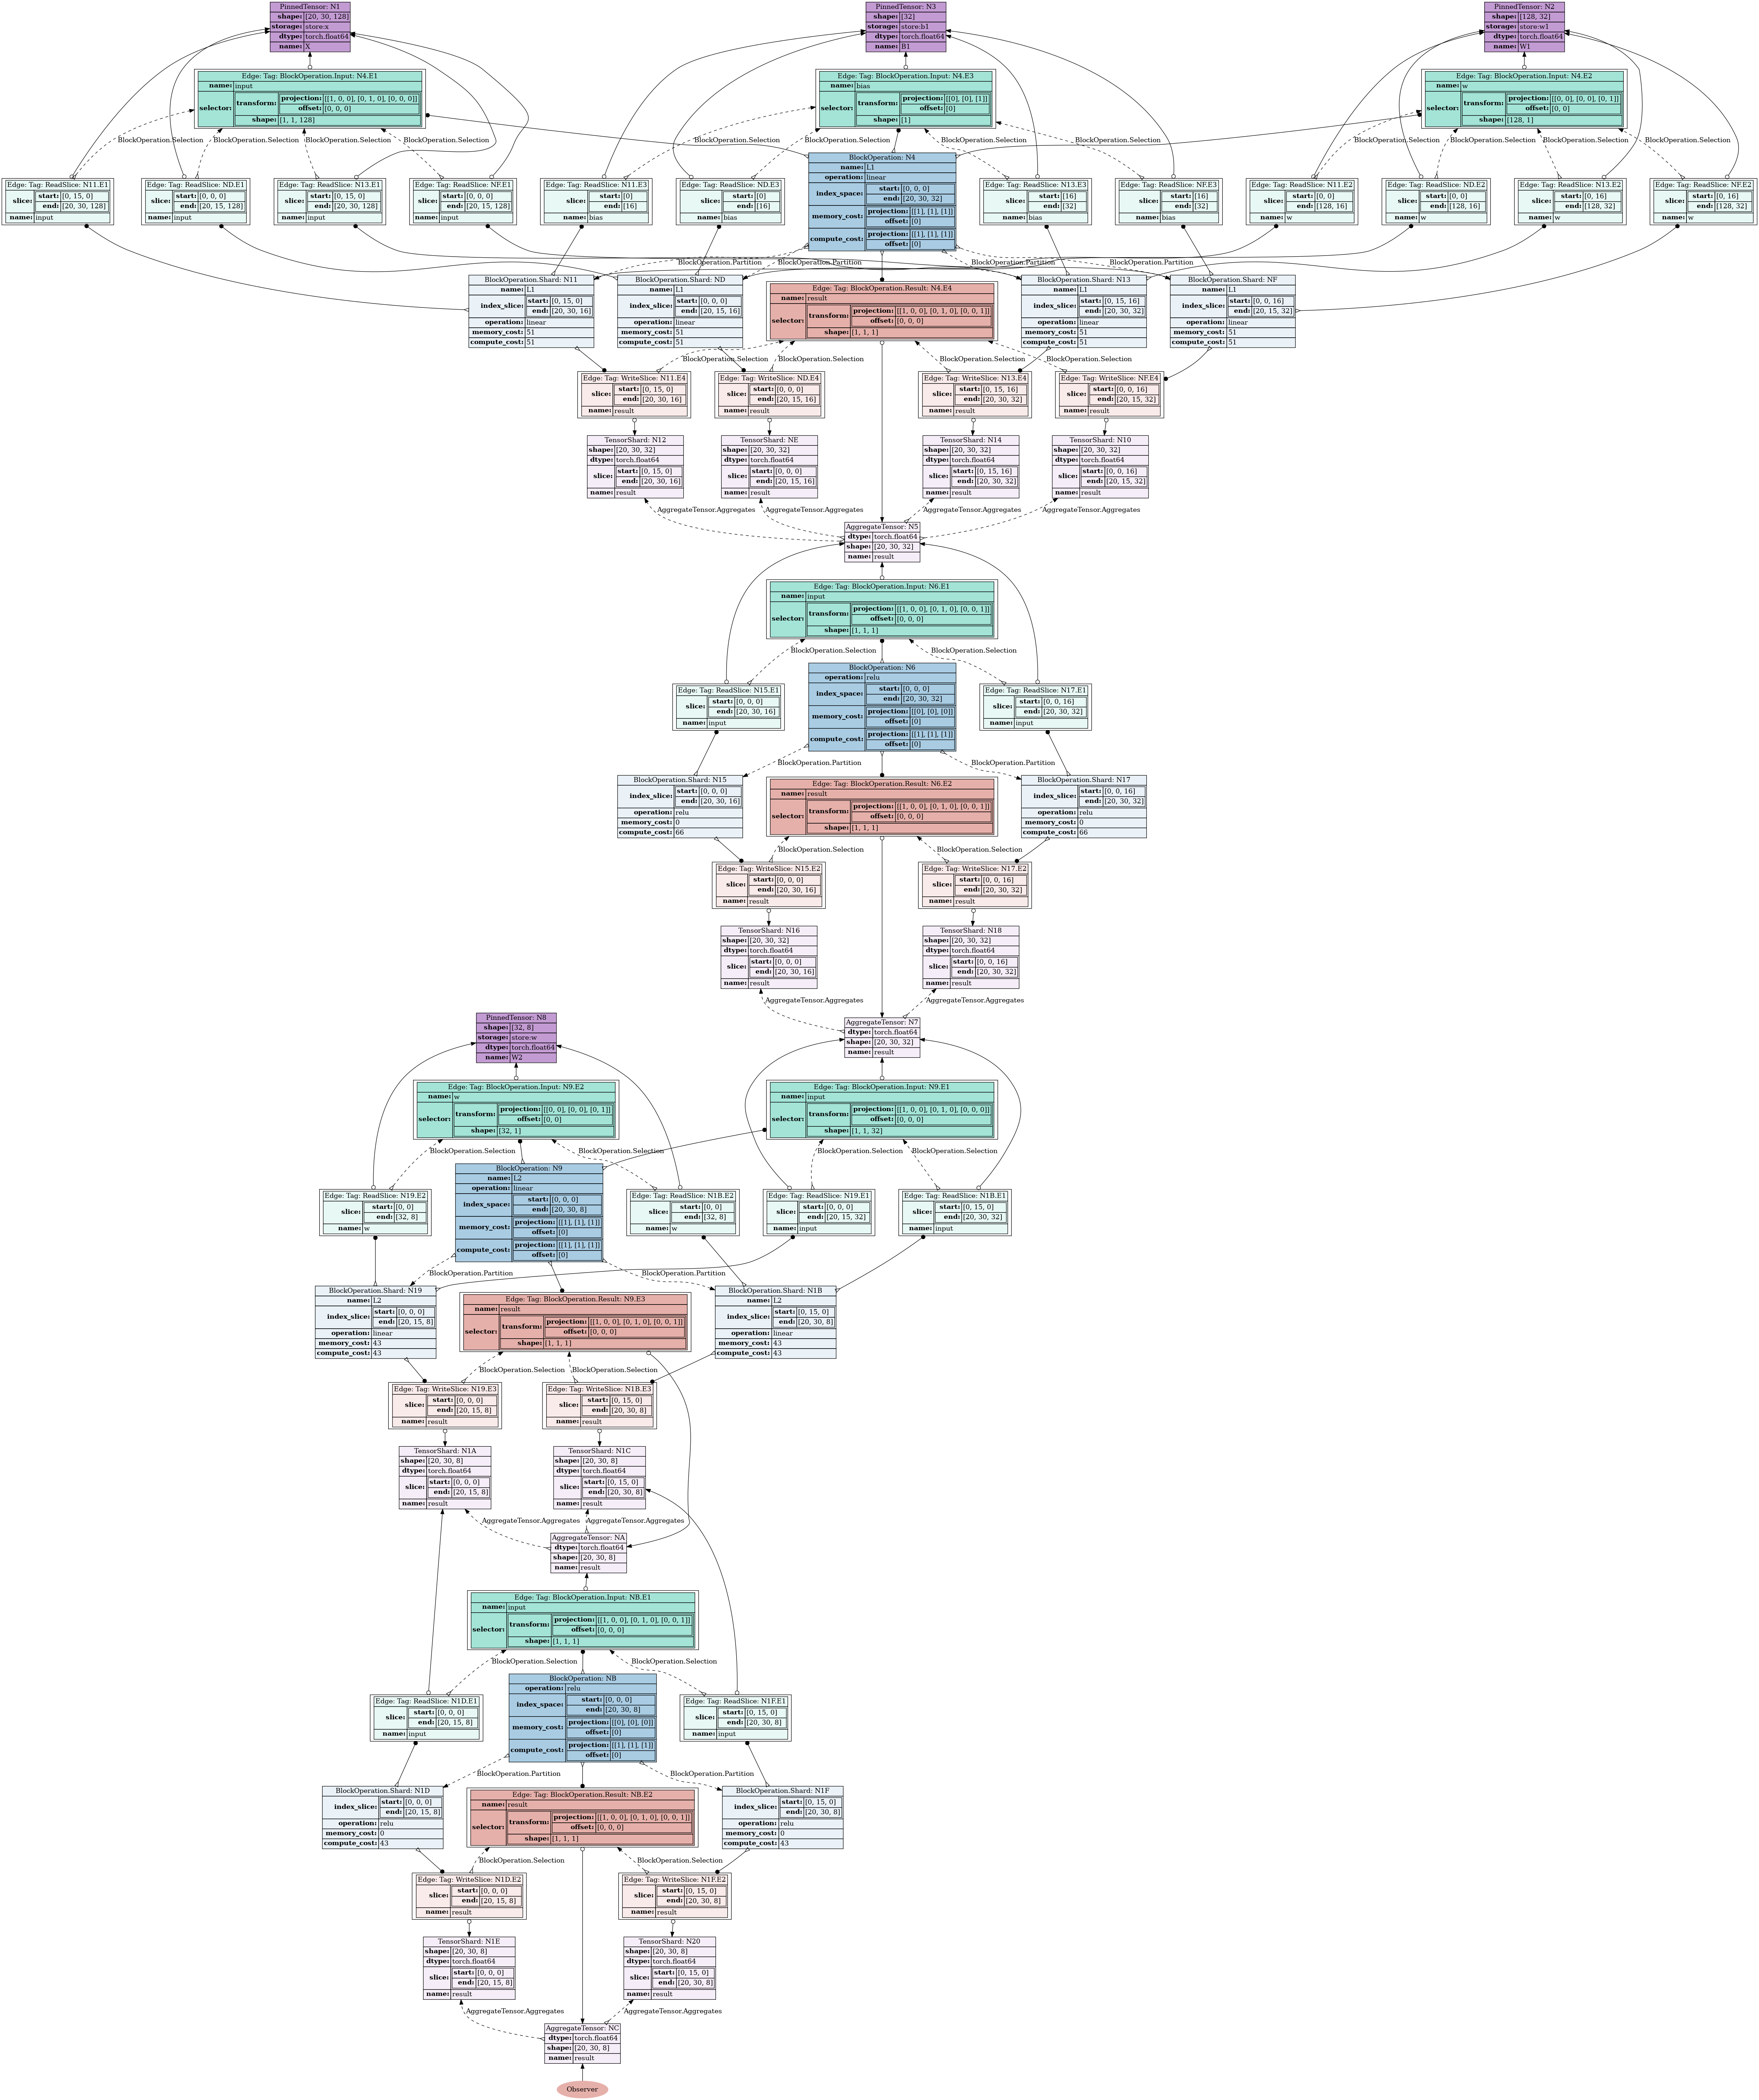

In [4]:
sharded = sectioned.clone()
expand_section_plans(sharded)
specialize_read_slices(sharded)
display_graph(sharded)

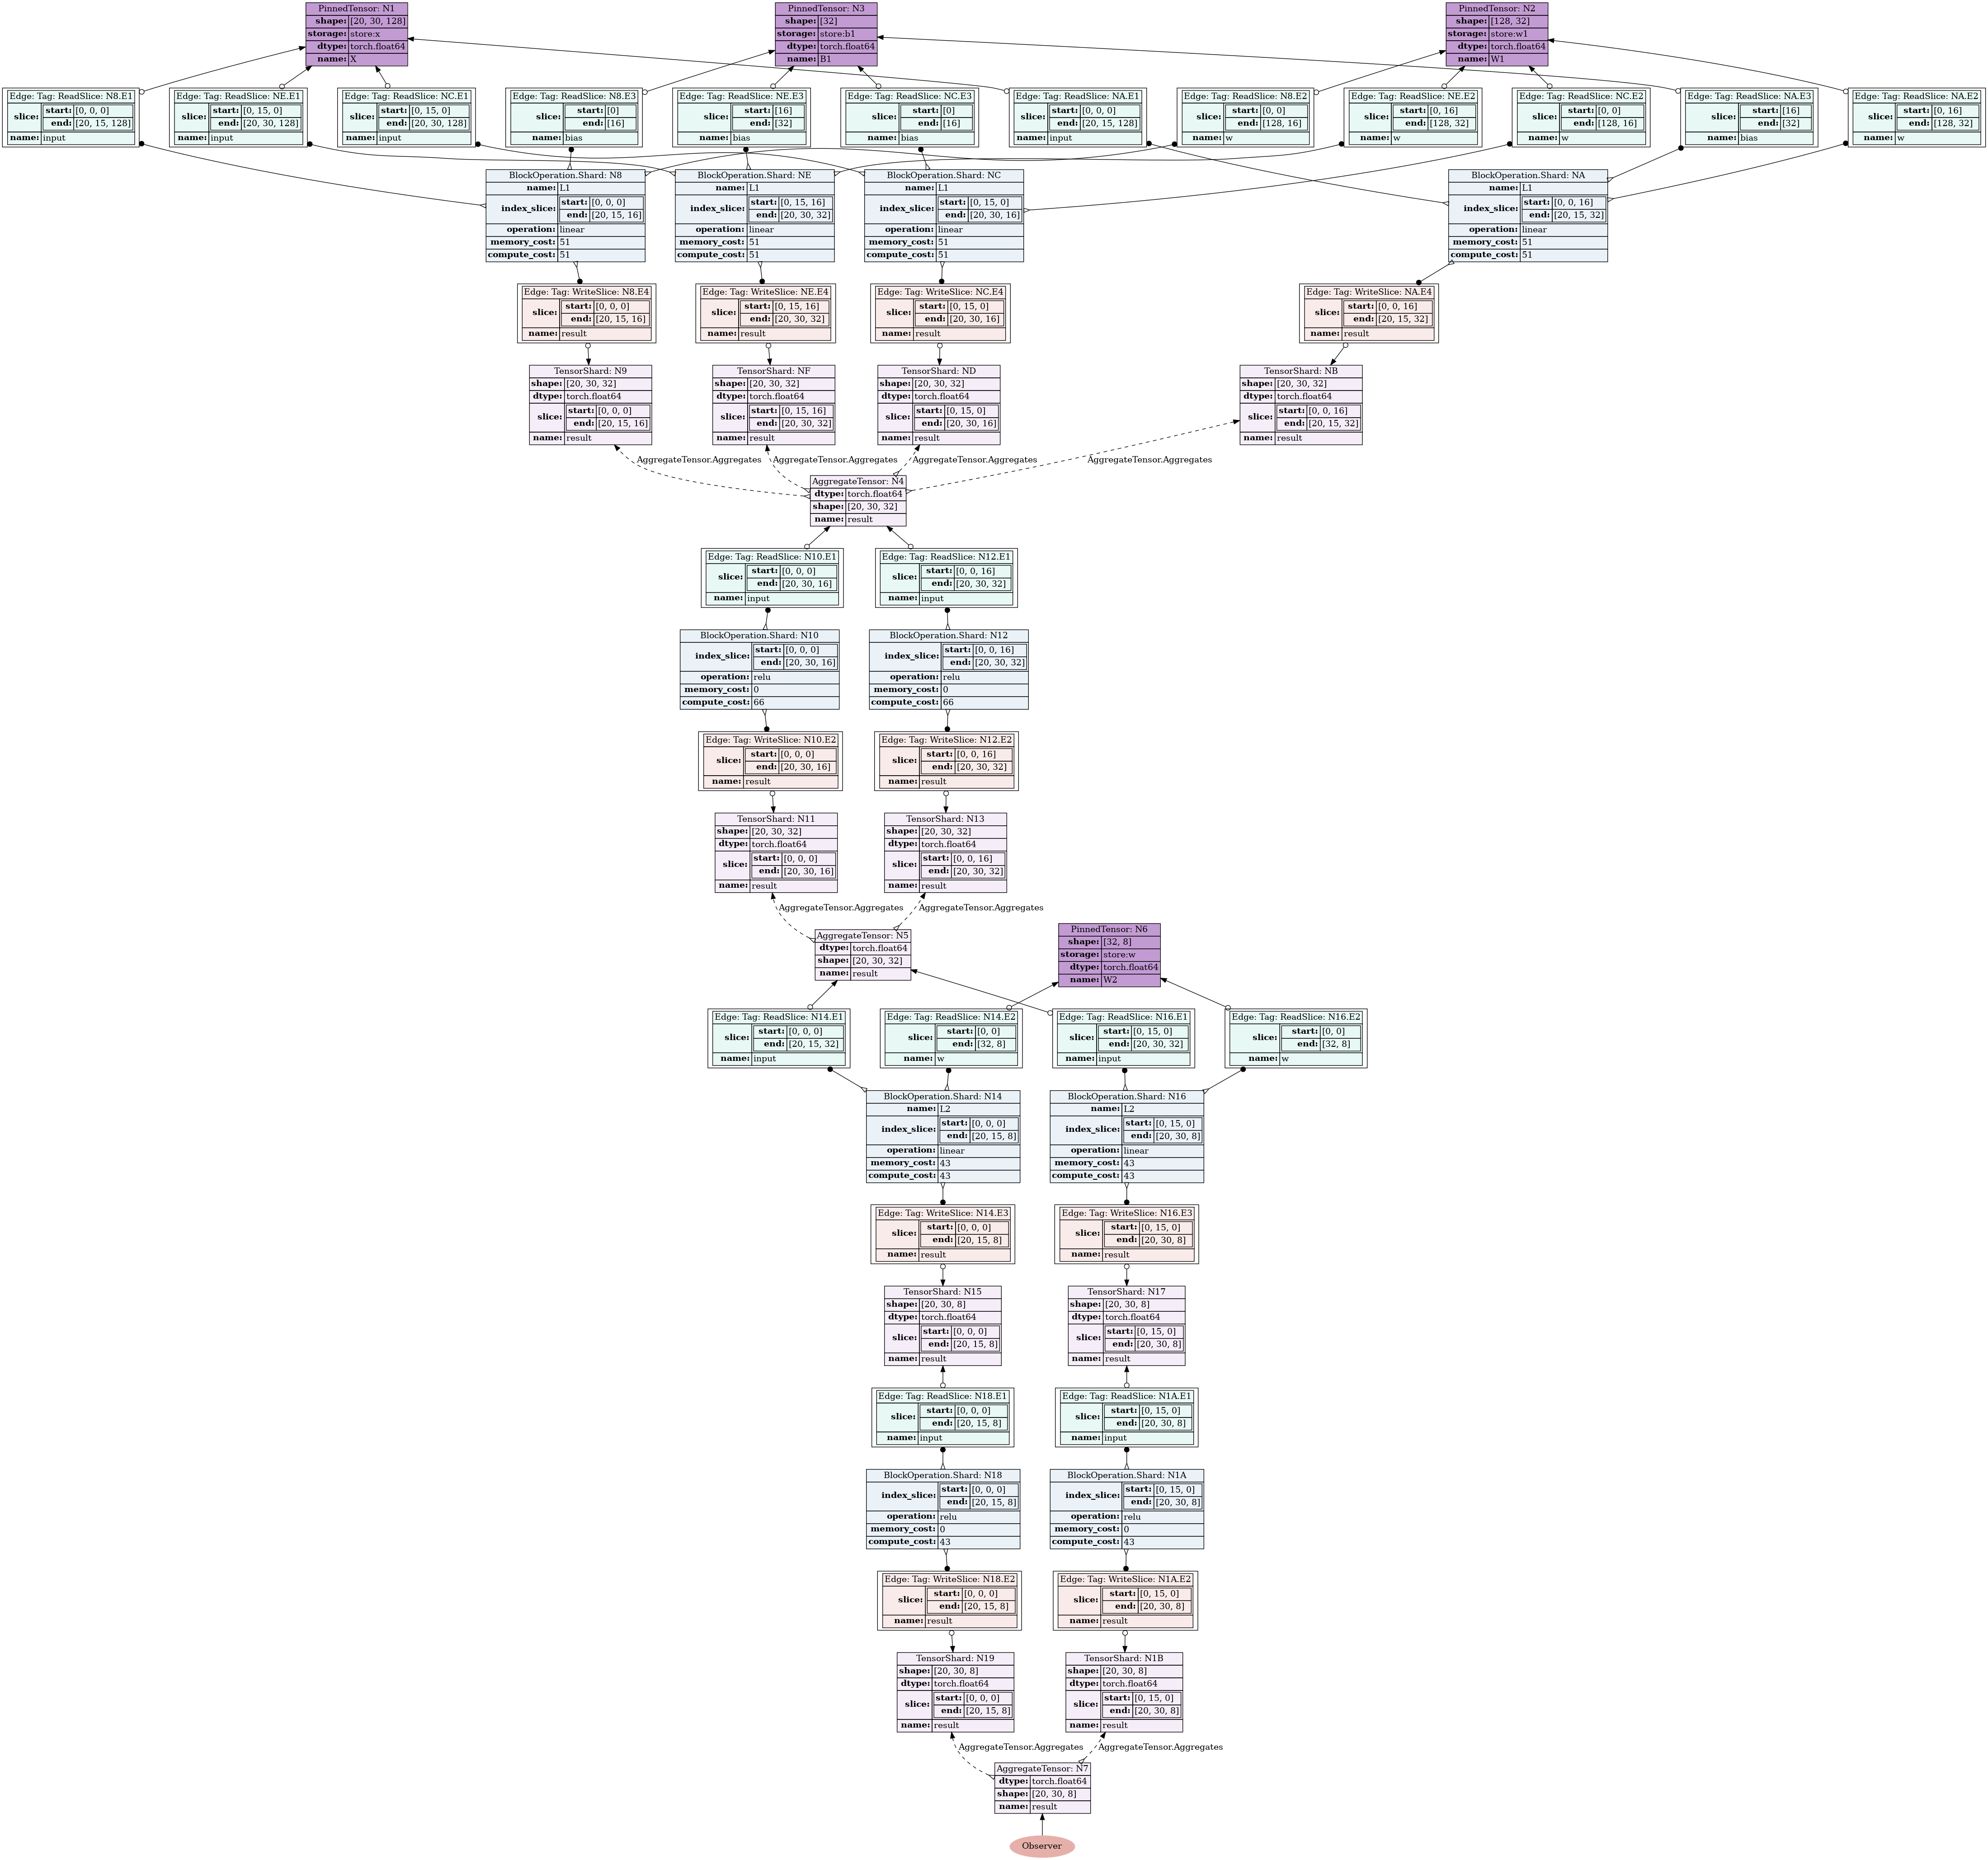

In [5]:
shard_only = sharded.clone()
strip_blocks(shard_only)
strip_orphan_values(shard_only)
display_graph(shard_only)

In [6]:
from tapestry import evaluate

pinned_values = {}
for pinned in shard_only.list_nodes(PinnedTensor):
    pinned_values[pinned.node_id] = torch.rand(tuple(pinned.shape), dtype=pinned.dtype)

operations = {
    "linear": linear_impl,
    "relu": relu_impl,
}


def evaluate_graph(
    g: TapestryGraph,
    inputs: Dict[uuid.UUID, torch.Tensor],
    bound_operations: Dict[str, evaluate.OpType],
) -> Tuple[Dict[uuid.UUID, torch.Tensor], evaluate.Environment]:
    env = evaluate.Environment()
    env.values.update(inputs)
    env.operations.update(bound_operations)

    obs = {node_id: g.get_node(node_id) for node_id in g.observed}
    vals = {}

    for node in obs.values():
        vals[node.node_id] = evaluate_tensor_value(node, env=env)

    return vals, env


v1, _env = evaluate_graph(shard_only, pinned_values, operations)

simple = unsharded.clone()
shard_max_dim(simple, 1)
v2, _env = evaluate_graph(simple, pinned_values, operations)

for k, v in v2.items():
    torch.testing.assert_allclose(v1[k], v)

display(v2)

{UUID('bbdc42f9-19db-4f59-baaf-15f1a1816f7f'): tensor([[[594.7963, 476.5045, 383.0318,  ..., 485.5612, 395.6625, 423.1830],
          [676.0625, 541.3803, 434.7560,  ..., 552.6283, 446.9739, 482.7532],
          [628.8879, 502.9199, 403.6917,  ..., 513.5451, 415.4458, 443.9817],
          ...,
          [682.4319, 547.0412, 438.9219,  ..., 557.3101, 453.6251, 486.3609],
          [694.4298, 555.9860, 449.9922,  ..., 569.4847, 462.9006, 498.3006],
          [671.4823, 539.4367, 432.4345,  ..., 549.7793, 446.9053, 481.6644]],
 
         [[653.9009, 525.9659, 422.7939,  ..., 535.7360, 435.9999, 470.4797],
          [616.8983, 489.6373, 394.7279,  ..., 503.4286, 406.3105, 439.7240],
          [626.3649, 497.9677, 401.2155,  ..., 509.7621, 413.3580, 445.0323],
          ...,
          [655.3275, 528.4436, 424.3456,  ..., 539.0687, 436.2764, 470.7516],
          [658.4684, 528.0738, 424.9426,  ..., 539.8750, 437.6543, 470.7314],
          [715.9715, 572.6438, 459.6573,  ..., 585.5917, 476.89